In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix


df = pd.read_csv('Spotify_Youtube.csv')


df = df[['Artist', 'Track', 'Danceability', 'Energy', 'Loudness', 'Valence', 'Views', 'Likes']]


df = df.dropna(subset=['Danceability', 'Energy', 'Loudness', 'Valence', 'Views', 'Likes']).reset_index(drop=True)

# Normalization
scaler = MinMaxScaler()
df[['Danceability', 'Energy', 'Loudness', 'Valence', 'Views', 'Likes']] = scaler.fit_transform(
    df[['Danceability', 'Energy', 'Loudness', 'Valence', 'Views', 'Likes']]
)

df.head()


,Artist,Track,Danceability,Energy,Loudness,Valence,Views,Likes
0,Gorillaz,Feel Good Inc.,0.838974,0.704994,0.838905,0.777442,0.085840,0.122486
1,Gorillaz,Rhinestone Eyes,0.693333,0.702994,0.857222,0.858006,0.008913,0.021247
2,Gorillaz,New Gold (feat. Tame Impala and Bootie Brown),0.712821,0.922998,0.897183,0.554884,0.001044,0.005555
3,Gorillaz,On Melancholy Hill,0.706667,0.738995,0.857328,0.582075,0.026208,0.035216
4,Gorillaz,Clint Eastwood,0.680000,0.693994,0.797609,0.528701,0.076548,0.122022


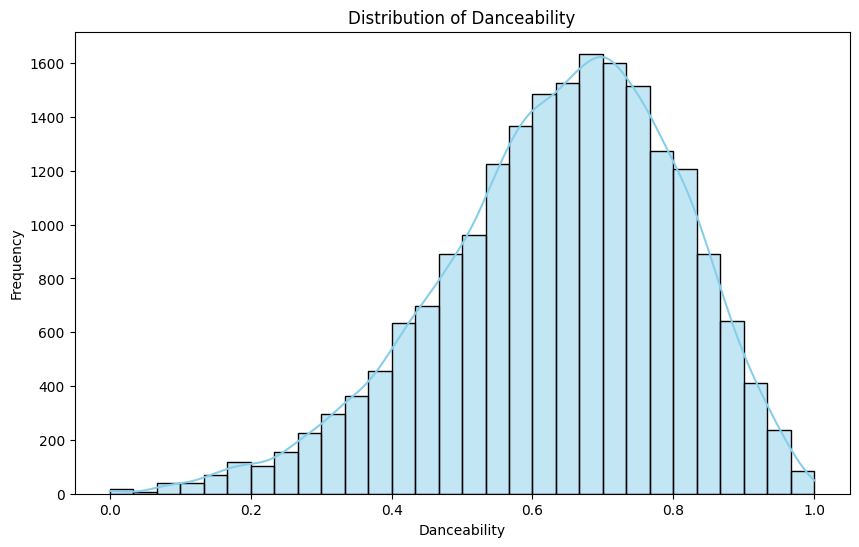

In [2]:
# Data Visualization

plt.figure(figsize=(10, 6))
sns.histplot(df['Danceability'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Danceability")
plt.xlabel("Danceability")
plt.ylabel("Frequency")
plt.show()

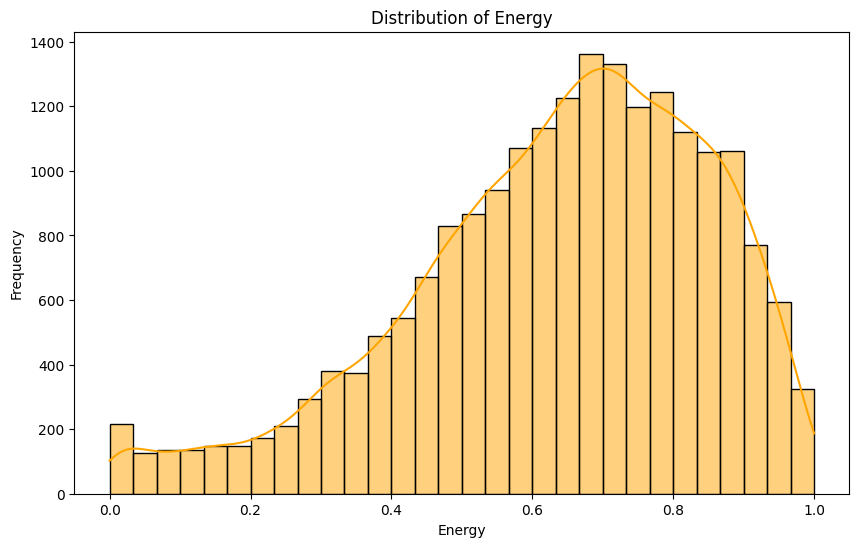

In [3]:

plt.figure(figsize=(10, 6))
sns.histplot(df['Energy'], kde=True, bins=30, color='orange')
plt.title("Distribution of Energy")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

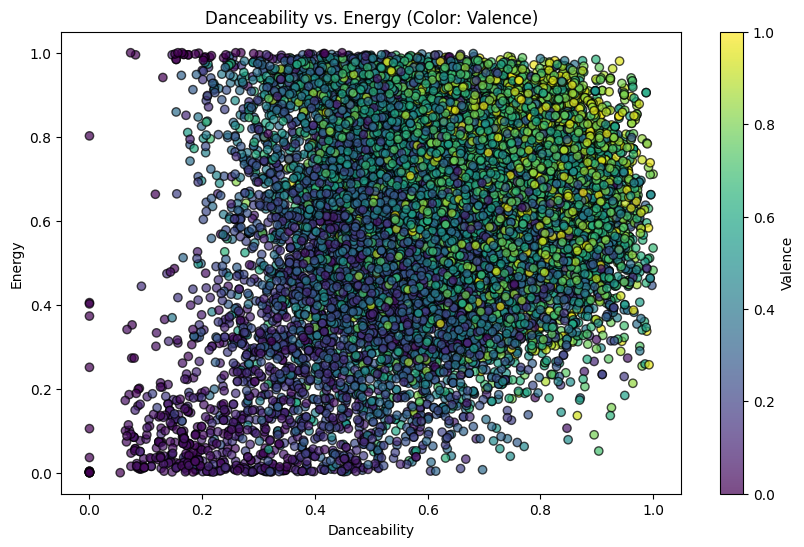

In [ ]:

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Danceability'], df['Energy'], c=df['Valence'], cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Valence')  
plt.title("Danceability vs. Energy (Color: Valence)")
plt.xlabel("Danceability")
plt.ylabel("Energy")
plt.show()


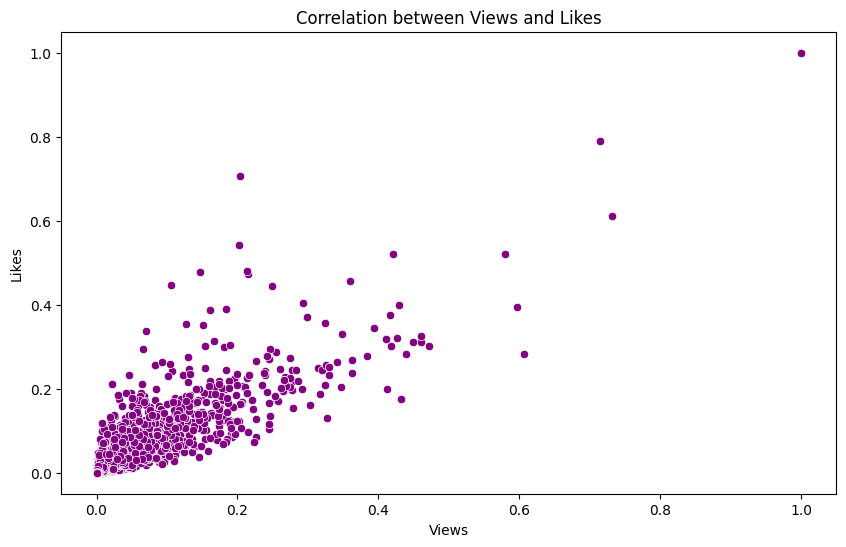

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Views', y='Likes', color='purple')
plt.title("Correlation between Views and Likes")
plt.xlabel("Views")
plt.ylabel("Likes")
plt.show()

In [ ]:
# Simulate user interactions
num_users = 1000
num_interactions = 5000
user_ids = np.random.randint(1, num_users + 1, num_interactions)
track_ids = np.random.choice(df.index, num_interactions)
user_track_df = pd.DataFrame({'user_id': user_ids, 'track_id': track_ids, 'interaction': 1})

# remove duplicates
user_track_df = user_track_df.groupby(['user_id', 'track_id']).sum().reset_index()
user_track_df['interaction'] = user_track_df['interaction'].apply(lambda x: 1 if x > 1 else x)

# Creating user-item matrix
user_track_matrix = user_track_df.pivot(index='user_id', columns='track_id', values='interaction').fillna(0)


# Training the KNN model
user_track_sparse_matrix = csr_matrix(user_track_matrix.values)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_track_sparse_matrix.T)  

# recommendation function
def get_track_recommendations(track_id, df, user_track_matrix, model, n_recommendations=5):
    track_idx = user_track_matrix.columns.get_loc(track_id)
    distances, indices = model.kneighbors(
        user_track_matrix.values.T[track_idx].reshape(1, -1), n_neighbors=n_recommendations + 1
    )
    recommended_track_indices = indices.flatten()[1:]  
    recommended_tracks = user_track_matrix.columns[recommended_track_indices]
    return df.loc[recommended_tracks, ['Artist', 'Track', 'Danceability', 'Energy', 'Loudness', 'Valence', 'Views', 'Likes']]


sample_track_id = user_track_matrix.columns[0]
recommended_tracks = get_track_recommendations(sample_track_id, df, user_track_matrix, model_knn)
print("\nRecommended Tracks:\n", recommended_tracks)


Recommended Tracks:
                    Artist                                  Track  \
track_id                                                           
13702          Carin Leon                              El Tóxico   
0                Gorillaz                         Feel Good Inc.   
6519      Gavin Greenaway  Elysium - From "Gladiator" Soundtrack   
13539              Kimbra                                replay!   
13520       Colby O'Donis               #1 - Colby O'Donis Remix   

          Danceability    Energy  Loudness   Valence     Views     Likes  
track_id                                                                  
13702         0.642051  0.502990  0.872655  0.826788  0.056888  0.035173  
0             0.838974  0.704994  0.838905  0.777442  0.085840  0.122486  
6519          0.123077  0.073481  0.444489  0.038066  0.006067  0.004410  
13539         0.826667  0.611992  0.772636  0.460222  0.000036  0.000223  
13520         0.781538  0.863997  0.881156  0.61228

In [ ]:
# Generating playlist

def generate_playlist(user_id, df, user_track_matrix, model, n_recommendations=5):
    user_tracks = user_track_matrix.loc[user_id]
    liked_tracks = user_tracks[user_tracks > 0].index
    playlist = []
    for track in liked_tracks:
        recommendations = get_track_recommendations(track, df, user_track_matrix, model, n_recommendations)
        playlist.extend(recommendations.values.tolist())  
    playlist = [list(track) for track in set(tuple(track) for track in playlist) if track[1] not in liked_tracks]  
    
    
    playlist_df = pd.DataFrame(playlist, columns=['Artist', 'Track', 'Danceability', 'Energy', 'Loudness', 'Valence', 'Views', 'Likes'])
    return playlist_df


sample_user_id = user_track_matrix.index[0]
user_playlist = generate_playlist(sample_user_id, df, user_track_matrix, model_knn)
print("\nGenerated Playlist for User ID:", sample_user_id)
display(user_playlist)


Generated Playlist for User ID: 1


,Artist,Track,Danceability,Energy,Loudness,Valence,Views,Likes
0,Deep Purple,Black Night,0.509744,0.786996,0.746476,0.817724,9.980626e-04,0.000896
1,Joe Hisaishi,Opening Song - Merry-Go-Round of Life,0.333333,0.094682,0.537746,0.095569,7.426290e-04,0.004554
2,Damian Marley,Love With A Quality,0.870769,0.751995,0.900871,0.590131,1.248932e-02,0.009918
3,Migos,Pure Water (with Migos),0.699487,0.558991,0.862945,0.137966,2.547137e-02,0.026728
4,Sleepy Hallow,Low Key (Bonus),0.906667,0.493990,0.856501,0.966767,6.137643e-07,0.000001
5,Hozier,Blood Upon the Snow,0.331282,0.300986,0.692947,0.277946,3.591915e-04,0.001416
6,Colby O'Donis,#1 - Colby O'Donis Remix,0.781538,0.863997,0.881156,0.612286,6.201969e-03,0.006283
7,Last Child,Sekuat Hatimu,0.515897,0.678993,0.865383,0.318228,7.388139e-03,0.004733
